# 使用Cifar10練習影像分類，遷移學習

In [2]:
#匯入函式庫，數值矩陣計算numpy，以及畫圖用的matplotlib
import numpy as np
import matplotlib.pyplot as plt

#匯入
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [3]:
#匯入tensorflow的函式庫，以及cifar10
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [4]:
#註：呼叫這些功能的寫法有兩種，以cifar10為例
#一、直接打一整串：tf.keras.datasets.cifar10.load_data()
#二、在一開始的地方使用from tensorflow.keras.datasets import cifar10，以後只要用cifar10.load_data()即可

## 讀取與檢視資料

In [5]:
#使用cifar10的資料集
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [6]:
X_train.shape

(50000, 32, 32, 3)

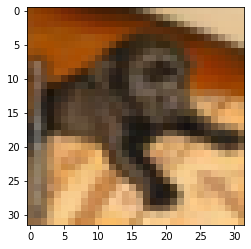

In [7]:
plt.imshow(X_train[56])

In [8]:
# 0 : airplain (飛機)
# 1 : automobile (汽車)
# 2 : bird (鳥)
# 3 : cat (貓)
# 4 : deer (鹿)
# 5 : dog (狗)
# 6 : frog (青蛙)
# 7 : horse (馬)
# 8 : ship (船)
# 9 : truck (卡車)

## 影像前處理

In [9]:
#對影像作正規化
x_train = X_train.astype('float32')/255
x_test = X_test.astype('float32')/255

In [10]:
#對類別資料作One-hot encoding
y_train = tf.keras.utils.to_categorical(Y_train)
y_test = tf.keras.utils.to_categorical(Y_test)

## 建立AI模型

In [18]:
#撰寫模型
input_layer=tf.keras.layers.Input(shape=(32,32,3))

x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu')(input_layer)
x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu')(x)
x=tf.keras.layers.MaxPool2D()(x)


#殘差網路撰寫範例------------------
x_shortcut = x

x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation('relu')(x)

x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.Add()([x, x_shortcut])
x=tf.keras.layers.Activation('relu')(x)

#----------------
x_shortcut = x

x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation('relu')(x)

x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.Add()([x, x_shortcut])
x=tf.keras.layers.Activation('relu')(x)
#-----------------------------------------

x=tf.keras.layers.AveragePooling2D()(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(32, activation='relu')(x)
#x=tf.keras.layers.Dropout(0.3)(x)

output_layer=tf.keras.layers.Dense(10, activation='softmax')(x)

In [19]:
model=tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [20]:
#data augmentation相關設定
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)  

## 開始訓練

In [21]:
#告訴AI學習的方式
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [22]:
#將訓練的模型置放於model_path下的model_name
model_name = 'cirfar10'

save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)

In [23]:
#設定模型存放方式(只存Validation表現最好的那一次)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

#設定多久沒進步就停下來
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)

In [24]:
#開始訓練，順便把訓練過程存到model_history，方便後續畫圖
model_history=model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=70, 
                        steps_per_epoch=len(x_train)/32, validation_data=(x_test,y_test), callbacks=[earlystop, checkpoint])

Epoch 1/70
1563/1562 [==============================] - ETA: 0s - loss: 1.6637 - categorical_accuracy: 0.4014
Epoch 00001: val_loss improved from inf to 1.92342, saving model to /root/chest x-ray/image_classification/saved_models/cirfar10
INFO:tensorflow:Assets written to: /root/chest x-ray/image_classification/saved_models/cirfar10/assets
1563/1562 [==============================] - 39s 25ms/step - loss: 1.6637 - categorical_accuracy: 0.4014 - val_loss: 1.9234 - val_categorical_accuracy: 0.3649
Epoch 2/70
1561/1562 [============================>.] - ETA: 0s - loss: 1.3393 - categorical_accuracy: 0.5145
Epoch 00002: val_loss improved from 1.92342 to 1.37676, saving model to /root/chest x-ray/image_classification/saved_models/cirfar10
INFO:tensorflow:Assets written to: /root/chest x-ray/image_classification/saved_models/cirfar10/assets
1563/1562 [==============================] - 38s 24ms/step - loss: 1.3393 - categorical_accuracy: 0.5145 - val_loss: 1.3768 - val_categorical_accuracy: 0

## 畫圖

In [25]:
model_history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [26]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['categorical_accuracy']
val_acc = model_history.history['val_categorical_accuracy']

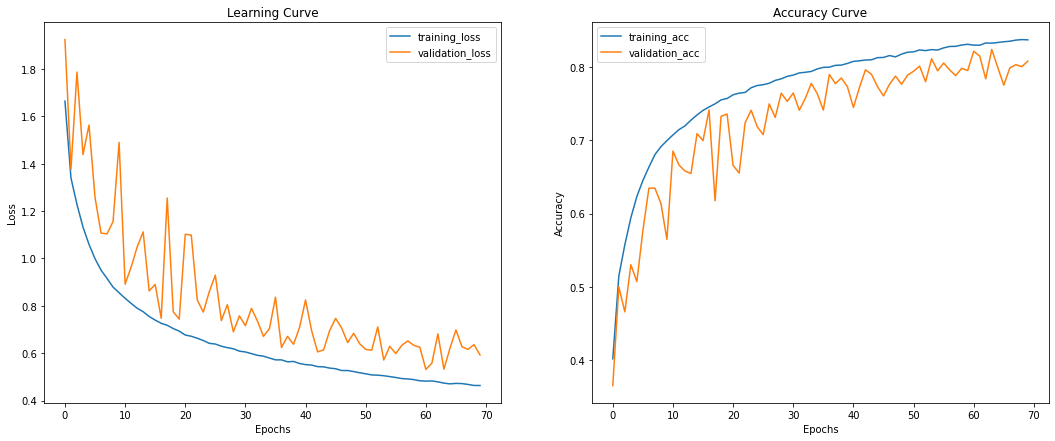

In [27]:
#畫圖
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.legend(loc='upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc='best')

plt.show()

## 作預測

In [28]:
#載入訓練好的模型
model = tf.keras.models.load_model(model_path)

In [29]:
#使用AI模型作預測
pred=model.predict(x_test)

In [30]:
#將預測的機率轉換成類別
ans=np.argmax(pred, axis=-1)

In [31]:
#畫出混淆矩陣
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(Y_test, ans)
print(cf_matrix)

[[881  20  19   6   5   0   4   8  31  26]
 [ 11 951   2   0   0   1   1   0   6  28]
 [ 73   8 751  19  35  26  56  16   9   7]
 [ 38   9  68 563  45 156  67  19  22  13]
 [ 14   4  70  16 760  31  50  45   9   1]
 [ 14   2  54  77  23 776  10  34   2   8]
 [ 12   5  39  18   9   5 893   5   9   5]
 [ 18   4  23  11  23  25   4 885   3   4]
 [ 64  22   4   2   1   0   2   0 886  19]
 [ 24  79   3   2   1   1   2   5   9 874]]


<AxesSubplot:>

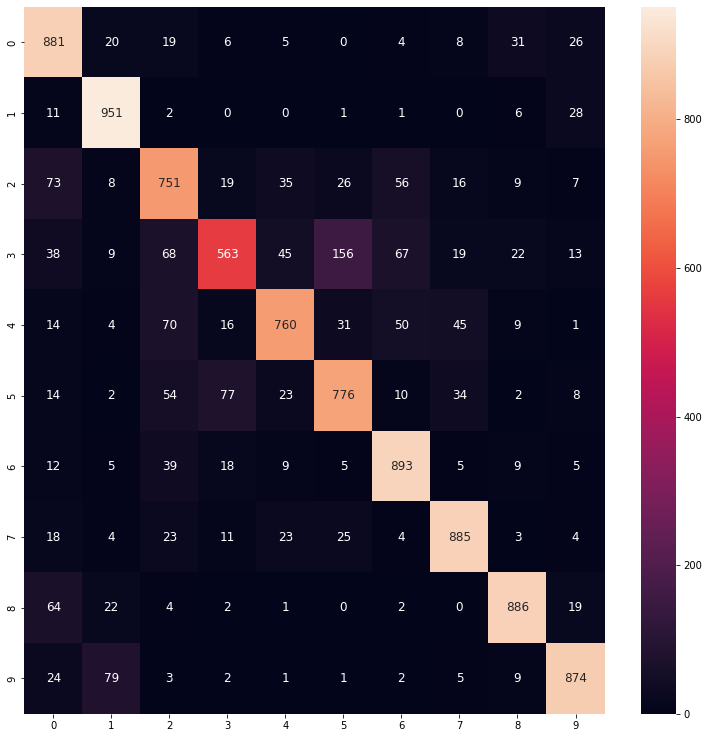

In [32]:
#對混淆矩陣畫圖
import seaborn as sns
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(cf_matrix, fmt='g', annot=True, annot_kws={"size":12})

In [33]:
#計算統計指標
from sklearn.metrics import classification_report
report = classification_report(Y_test, ans)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1000
           1       0.86      0.95      0.90      1000
           2       0.73      0.75      0.74      1000
           3       0.79      0.56      0.66      1000
           4       0.84      0.76      0.80      1000
           5       0.76      0.78      0.77      1000
           6       0.82      0.89      0.85      1000
           7       0.87      0.89      0.88      1000
           8       0.90      0.89      0.89      1000
           9       0.89      0.87      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

